In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
WORKSPACE='uqml'
RESOURCE_GROUP='uqml'
SUBSCRIPTION_ID='96185854-d711-439b-bfa4-fc8abfc8983c'

## create experiment

In [3]:
from azureml.core import Workspace, Experiment

ws = Workspace.get(
    name=WORKSPACE,
    subscription_id=SUBSCRIPTION_ID,
    resource_group=RESOURCE_GROUP,
)
exp = Experiment(workspace=ws, name="optimizing_ml_pipeline")

print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

run = exp.start_logging()

Workspace name: uqml
Azure region: uksouth
Subscription id: 96185854-d711-439b-bfa4-fc8abfc8983c
Resource group: uqml


In [4]:
for run in exp.get_runs():
    if run.status=="Running":
        print(f'cancelling {run.id}')
        run.cancel()

cancelling 411e7652-4ef2-4f4d-b370-8092b7adf2bf


## create a compute cluster

In [5]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "mlopscluster"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6',
                                                           max_nodes=4)
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## create conda environment file and register environment

In [6]:
%%writefile conda_dependencies.yml

dependencies:
- python=3.6.2
- scikit-learn
- pip:
  - azureml-defaults

Overwriting conda_dependencies.yml


In [7]:
from azureml.core import Environment
sklearn_env = Environment.from_conda_specification(name = 'sklearn-env', file_path = './conda_dependencies.yml')

# 1 - hyperdrive config

## setup hyperdrive config and submit

In [23]:
from azureml.widgets import RunDetails
from azureml.train.sklearn import SKLearn
from azureml.core import ScriptRunConfig
from azureml.train.hyperdrive.run import PrimaryMetricGoal
from azureml.train.hyperdrive.policy import BanditPolicy
from azureml.train.hyperdrive.sampling import RandomParameterSampling
from azureml.train.hyperdrive.runconfig import HyperDriveConfig
from azureml.train.hyperdrive.parameter_expressions import uniform, normal, choice, quniform
import os


# Specify parameter sampler
ps = RandomParameterSampling( {
    "--C": choice(0.001, 0.01, 0.1, 1, 10, 100, 1000),
    "--max_iter": choice(100, 200, 300, 400, 500)
} )

# Specify a Policy
policy = BanditPolicy(slack_factor = 0.1, evaluation_interval=3, delay_evaluation=1)

if "training" not in os.listdir():
    os.mkdir("./training")

# Create a SKLearn estimator for use with train.py
src = ScriptRunConfig(source_directory='.',
                      script='train.py',
                      compute_target=ws.compute_targets['mlopscluster'],
                      environment=sklearn_env)

# Create a HyperDriveConfig using the estimator, hyperparameter sampler, and policy.
hyperdrive_config = HyperDriveConfig(run_config=src,
                             hyperparameter_sampling=ps,
                             policy=policy,
                             primary_metric_name="accuracy",
                             primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                             max_total_runs=20,
                             max_concurrent_runs=)

hyperdrive_run = exp.submit(hyperdrive_config)

RunDetails(hyperdrive_run).show()

'SKLearn' estimator is deprecated. Please use 'ScriptRunConfig' from 'azureml.core.script_run_config' with your own defined environment or the AzureML-Tutorial curated environment.
'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


## inspect the results

In [40]:
# wait for the results and extract the best run
hyperdrive_run.wait_for_completion(show_output=True)
assert(hyperdrive_run.get_status() == "Completed")

best_run = hyperdrive_run.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()
parameter_values = best_run.get_details()['runDefinition']['arguments']

print('Best Run Id: ', best_run.id)
print(best_run_metrics)

RunId: HD_0af6bbed-bcf1-4d4a-907c-0d92094e85d5
Web View: https://ml.azure.com/runs/HD_0af6bbed-bcf1-4d4a-907c-0d92094e85d5?wsid=/subscriptions/96185854-d711-439b-bfa4-fc8abfc8983c/resourcegroups/uqml/workspaces/uqml&tid=5a488f9a-6465-4e8f-bbbe-e4c54aae2465

Execution Summary
RunId: HD_0af6bbed-bcf1-4d4a-907c-0d92094e85d5
Web View: https://ml.azure.com/runs/HD_0af6bbed-bcf1-4d4a-907c-0d92094e85d5?wsid=/subscriptions/96185854-d711-439b-bfa4-fc8abfc8983c/resourcegroups/uqml/workspaces/uqml&tid=5a488f9a-6465-4e8f-bbbe-e4c54aae2465

Best Run Id:  HD_0af6bbed-bcf1-4d4a-907c-0d92094e85d5_0
{'regularization_strength': 0.01, 'max_iterations': 200, 'accuracy': 0.9084366600190757}


# 2 - automl

In [30]:
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from azureml.data.dataset_factory import TabularDatasetFactory
from train import clean_data

ds=TabularDatasetFactory.from_delimited_files("https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_train.csv")

x, y = clean_data(ds)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.65,test_size=0.35, random_state=101)

In [31]:
from azureml.train.automl import AutoMLConfig
# Set parameters for AutoMLConfig
# NOTE: DO NOT CHANGE THE experiment_timeout_minutes PARAMETER OR YOUR INSTANCE WILL TIME OUT.
# If you wish to run the experiment longer, you will need to run this notebook in your own
# Azure tenant, which will incur personal costs.
automl_config = AutoMLConfig(
    experiment_timeout_minutes=15,
    task= 'classification',
    primary_metric='accuracy',
    training_data=x,
    label_column_name='y',
    n_cross_validations=2)

# Submit automl run
#experiment = Experiment(ws, "automl-experiment")
run = exp.submit(automl_config, show_output=True)



No run_configuration provided, running on local with default configuration
Running in the active local environment.


Experiment,Id,Type,Status,Details Page,Docs Page
optimizing_ml_pipeline,AutoML_d3764fac-b541-4a47-a74d-a2c0299114ed,automl,Preparing,Link to Azure Machine Learning studio,Link to Documentation


Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetBalancing. Performing class balancing sweeping
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       ALERTED
DESCRIPTION:  To decrease model bias, please cancel the current run and fix balancing problem.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData
DETAILS:      Imbalanced data can lead to a falsely perceived positive effect of a model's accuracy because the input data has bias toward

In [32]:
run.wait_for_completion(show_output=True)

Experiment,Id,Type,Status,Details Page,Docs Page
optimizing_ml_pipeline,AutoML_d3764fac-b541-4a47-a74d-a2c0299114ed,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation




****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       ALERTED
DESCRIPTION:  To decrease model bias, please cancel the current run and fix balancing problem.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData
DETAILS:      Imbalanced data can lead to a falsely perceived positive effect of a model's accuracy because the input data has bias towards one class.
+---------------------------------+---------------------------------+--------------------------------------+
|Size of the smallest class       |Name/Label of the smallest class |Number of samples in the training data|
+=================================+=================================+======================================+
|3692                             |yes                              |32950                                 |
+---------------------------------+----------

{'runId': 'AutoML_d3764fac-b541-4a47-a74d-a2c0299114ed',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2021-07-04T20:54:42.211777Z',
 'endTimeUtc': '2021-07-04T21:11:15.845537Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '2',
  'target': 'local',
  'AMLSettingsJsonString': '{"path":null,"name":"optimizing_ml_pipeline","subscription_id":"96185854-d711-439b-bfa4-fc8abfc8983c","resource_group":"uqml","workspace_name":"uqml","region":"uksouth","compute_target":"local","spark_service":null,"azure_service":"Microsoft.AzureNotebookVM","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"iterations":1000,"primary_metric":"accuracy","task_type":"classification","data_script":null,"test_size":0.0,"v

## get best run

In [42]:
best_run, fitted_model = run.get_output()
print(best_run)
print(fitted_model)

model = best_run.register_model(model_name = 'best_model_automl', model_path = 'outputs/model.pkl')


Run(Experiment: optimizing_ml_pipeline,
Id: AutoML_d3764fac-b541-4a47-a74d-a2c0299114ed_21,
Type: None,
Status: Completed)
Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                                                    min_samples_split=0.2442105263157895,
                                                                                                    min_weight_fraction_leaf=0.0,
 

In [47]:
best_run.get_file_names()

['accuracy_table',
 'confusion_matrix',
 'explanation/161864e2/classes.interpret.json',
 'explanation/161864e2/eval_data_viz.interpret.json',
 'explanation/161864e2/expected_values.interpret.json',
 'explanation/161864e2/features.interpret.json',
 'explanation/161864e2/global_names/0.interpret.json',
 'explanation/161864e2/global_rank/0.interpret.json',
 'explanation/161864e2/global_values/0.interpret.json',
 'explanation/161864e2/local_importance_values.interpret.json',
 'explanation/161864e2/per_class_names/0.interpret.json',
 'explanation/161864e2/per_class_rank/0.interpret.json',
 'explanation/161864e2/per_class_values/0.interpret.json',
 'explanation/161864e2/rich_metadata.interpret.json',
 'explanation/161864e2/true_ys_viz.interpret.json',
 'explanation/161864e2/visualization_dict.interpret.json',
 'explanation/c9b43996/classes.interpret.json',
 'explanation/c9b43996/expected_values.interpret.json',
 'explanation/c9b43996/features.interpret.json',
 'explanation/c9b43996/global_names/0.interpret.json',
 'explanation/c9b43996/global_rank/0.interpret.json',
 'explanation/c9b43996/global_values/0.interpret.json',
 'explanation/c9b43996/local_importance_values.interpret.json',
 'explanation/c9b43996/per_class_names/0.interpret.json',
 'explanation/c9b43996/per_class_rank/0.interpret.json',
 'explanation/c9b43996/per_class_values/0.interpret.json',
 'explanation/c9b43996/rich_metadata.interpret.json',
 'explanation/c9b43996/true_ys_viz.interpret.json',
 'explanation/c9b43996/visualization_dict.interpret.json',
 'explanation/c9b43996/ys_pred_proba_viz.interpret.json',
 'explanation/c9b43996/ys_pred_viz.interpret.json',
 'outputs/conda_env_v_1_0_0.yml',
 'outputs/env_dependencies.json',
 'outputs/internal_cross_validated_models.pkl',
 'outputs/model.pkl',
 'outputs/pipeline_graph.json',
 'outputs/scoring_file_v_1_0_0.py']

## plot top 3 features

<BarContainer object of 3 artists>

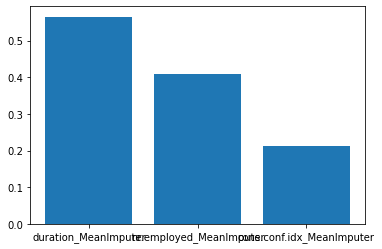

In [46]:
from azureml.interpret import ExplanationClient
import matplotlib.pyplot as plt

client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)

feature_importance_dict = engineered_explanations.get_feature_importance_dict()

# top 3 metrics
xx, yy = zip(*feature_importance_dict.items())
plt.bar(xx[:3], yy[:3])

## delete compute cluster

In [48]:
cpu_cluster.delete()